In [4]:
# Question 1

# Source: intro_NN

# Load the dataset

import pandas as pd
abalone = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None,
                   names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Rings'])

# Find unique values in Sex for mapping
abalone['Sex'].value_counts()

# We will predict Sex, which is categorical, so we need to convert it to numerical values
sex_codes = {'Sex': {"M": 0, "F": 1, "I": 2}}
abalone.replace(sex_codes, inplace=True)

# Drop last row from data set to avoid error in Part b
abalone.drop(abalone.tail(1).index,inplace=True)

In [5]:
# Question 1(a)
# Source: intro_NN

# We do a 50/50 split of the data into training and testing sets 
from sklearn.model_selection import train_test_split
train, test = train_test_split(abalone, test_size=0.5, random_state=42)
train_labels = train.iloc[:,-1]
train_data = train.drop(['Sex'], axis=1)
test_labels = test.iloc[:,-1]
test_data = test.drop(['Sex'], axis=1)
# For multiclass classification, we will use 'Sex' as the target
train_labels_mc = train['Sex']
test_labels_mc = test['Sex']

# Next, we scale our data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(train_data)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 512)               4608      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 268,803
Trainable params: 268,803
Non-trainable params: 0
_________________________________________________________________


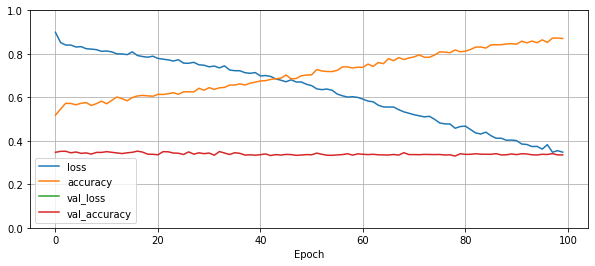

In [6]:
# Question 1(b)
# Source: intro_nn

# Train a poor deep neural network (DNN)
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[8]),
keras.layers.Dense(512, activation="relu"),
keras.layers.Dense(512, activation="relu"),
keras.layers.Dense(3, activation="softmax")
])

# Visualize the model

model.summary()

# Next, we establish the loss, optimizer, and metric
# According to this paper, https://opt-ml.org/papers/2021/paper53.pdf, Adam often leads to 
# worse generalization performance than SGD for training deep neural networks

model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Lastly, we will use the history object to create a graph

history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(test_data, test_labels_mc), verbose=0)

import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(loc = 'lower left')
plt.show()

In [8]:
# Question 1(c)
# Source: training_DNNs

# Improve the model using Keras Tuner

import IPython
!pip install -q -U keras-tuner
import kerastuner as kt

def model_builder(hp):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[8]))
  model.add(keras.layers.BatchNormalization())

# Tune the number of units in the two hidden layers:
  hp_units_1 = hp.Int('units_1', min_value = 8, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units_1, activation="relu"))
  model.add(keras.layers.BatchNormalization())
  hp_units_2 = hp.Int('units_2', min_value = 0, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units_2, activation="relu"))
  model. add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(100, activation='softmax'))

# Tune the optimizer:
  hp_optimizer = hp.Choice('optimizer', ['Adam', 'RMSProp', 'SGD', 'Adagrad', 'Adamax'])
  model.compile(optimizer = hp_optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
  return model

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

tuner = kt.Hyperband(model_builder, objective = 'val_loss', max_epochs = 100, factor = 3, overwrite = True)

tuner.search(train_data, train_labels, epochs = 100, validation_data=(test_data, test_labels), callbacks = [ClearTrainingOutput()])

Trial 254 Complete [00h 01m 21s]
val_loss: 4.409026622772217

Best val_loss So Far: 3.877796173095703
Total elapsed time: 00h 42m 21s


In [9]:
# Question 1(c) - Continued
# Source: training_DNNs

# Get the best parameters for our model

tuner.get_best_hyperparameters()[0].values

{'units_1': 328,
 'units_2': 32,
 'optimizer': 'RMSProp',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 8)                 0         
                                                                 
 batch_normalization_4 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 328)               2952      
                                                                 
 batch_normalization_5 (Batc  (None, 328)              1312      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 32)                10528     
                                                                 
 dropout_2 (Dropout)         (None, 32)               

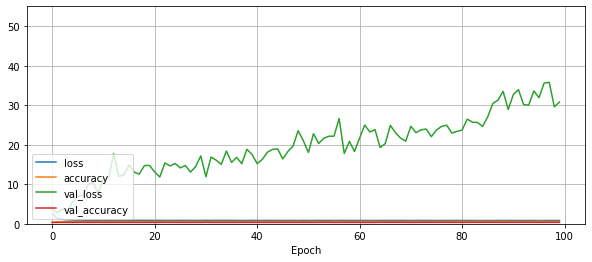

In [11]:
# Question 1(c) - Continued
# Source: training_DNNs

# Train the model on the bestparameters 
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model_e = tuner.hypermodel.build(best_hps)
history_e = model_e.fit(train_data, train_labels_mc, epochs = 100, validation_data = (test_data, test_labels_mc), verbose=0)
model_e.summary()


# Lastly, we use the history_e object to create a graph
pd.DataFrame(history_e.history).plot(figsize=(10, 4))
plt.grid(True)
plt.gca().set_ylim(0, 55)
plt.xlabel('Epoch')
plt.legend(loc = 'lower left')
plt.show()

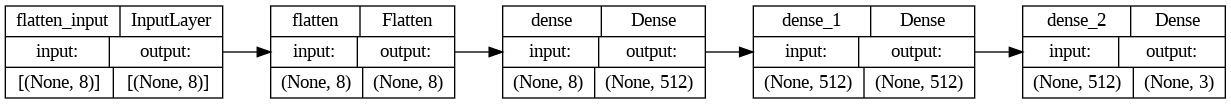

In [16]:
# Question 1(d) - b
# Source: training_DNNs

keras.utils.plot_model(model,"abalone-db.png", show_shapes=True, rankdir='LR') 

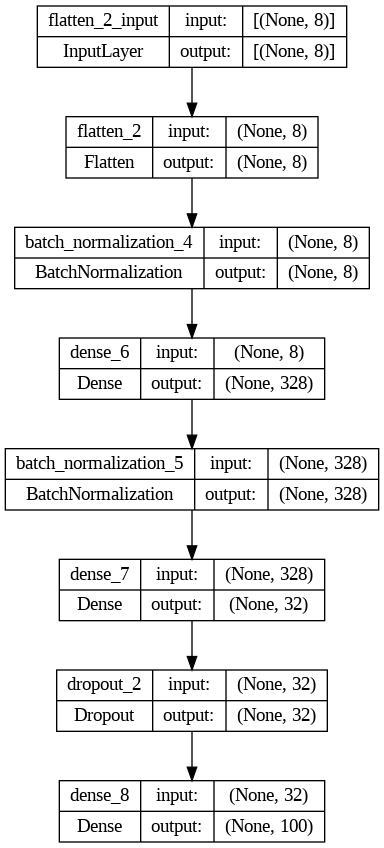

In [18]:
# Question 1(d) - c
# Source: training_DNNs

keras.utils.plot_model(model_e, "abalone-dc.png", show_shapes=True)